Neural Network from Scratch - Complete Implementation
EXPERIMENT 1: MNIST Classification
Epoch 10/100 - Loss: 0.6499, Acc: 0.8789, Val Loss: 0.6166, Val Acc: 0.8889
Epoch 20/100 - Loss: 0.3216, Acc: 0.9325, Val Loss: 0.3086, Val Acc: 0.9250
Epoch 30/100 - Loss: 0.2167, Acc: 0.9562, Val Loss: 0.2137, Val Acc: 0.9472
Epoch 40/100 - Loss: 0.1677, Acc: 0.9687, Val Loss: 0.1688, Val Acc: 0.9611
Epoch 50/100 - Loss: 0.1373, Acc: 0.9763, Val Loss: 0.1447, Val Acc: 0.9722
Epoch 60/100 - Loss: 0.1175, Acc: 0.9756, Val Loss: 0.1300, Val Acc: 0.9722
Epoch 70/100 - Loss: 0.1034, Acc: 0.9812, Val Loss: 0.1212, Val Acc: 0.9806
Epoch 80/100 - Loss: 0.0913, Acc: 0.9819, Val Loss: 0.1136, Val Acc: 0.9750
Epoch 90/100 - Loss: 0.0823, Acc: 0.9854, Val Loss: 0.1093, Val Acc: 0.9722
Epoch 100/100 - Loss: 0.0743, Acc: 0.9868, Val Loss: 0.1069, Val Acc: 0.9722

Final Test Accuracy: 97.22%


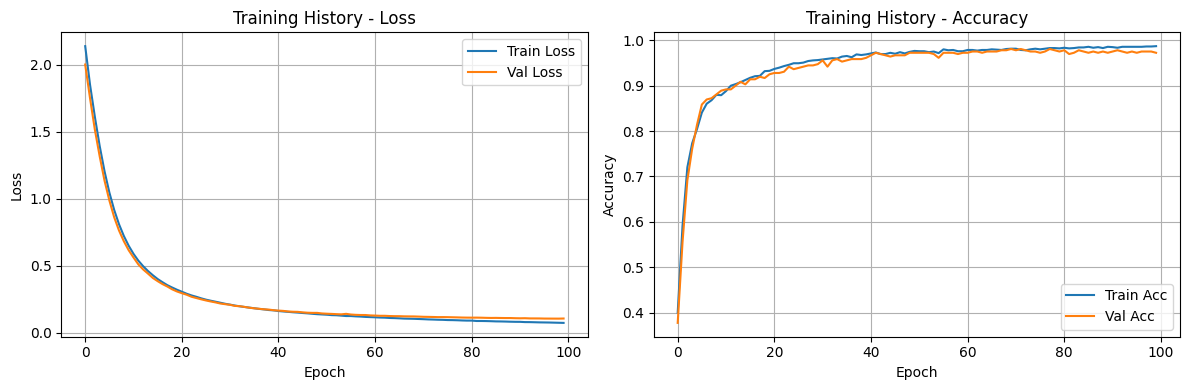


EXPERIMENT 2: Activation Function Comparison

Training with RELU...
Final Accuracy: 88.40%

Training with SIGMOID...
Final Accuracy: 79.80%

Training with TANH...
Final Accuracy: 89.20%


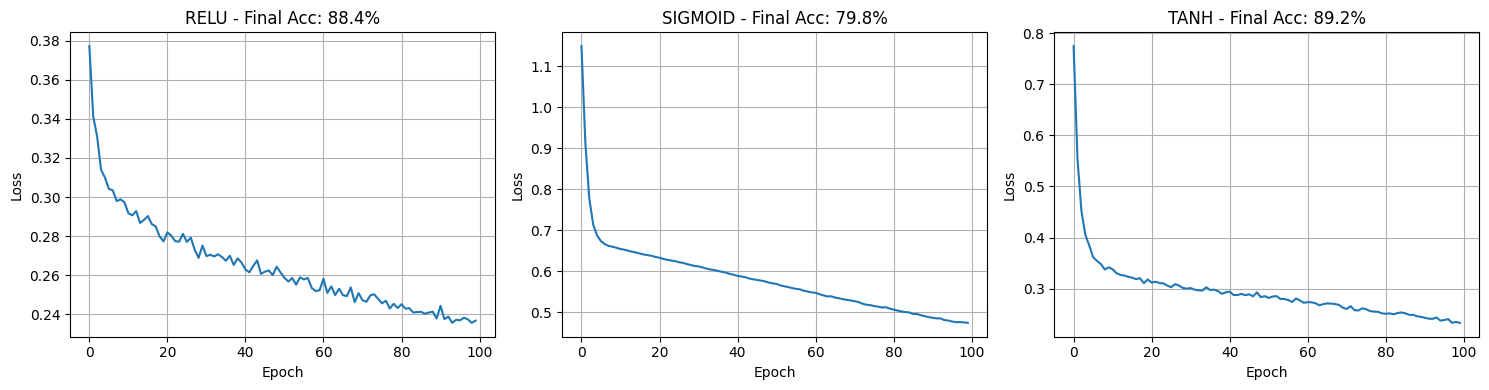

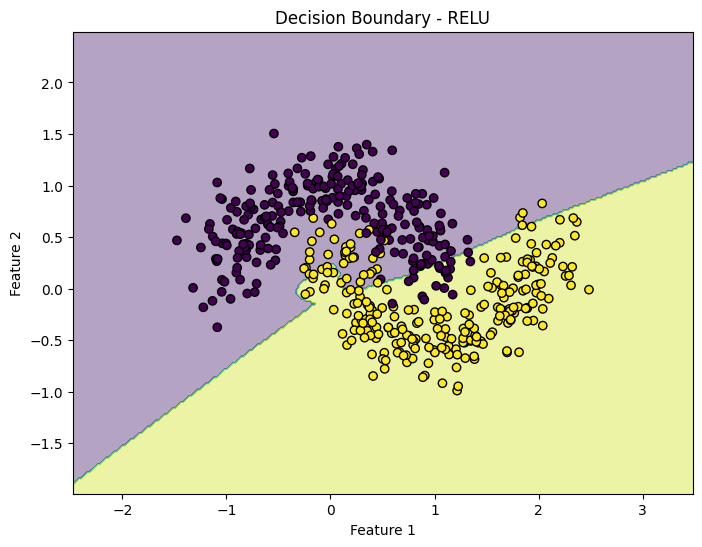

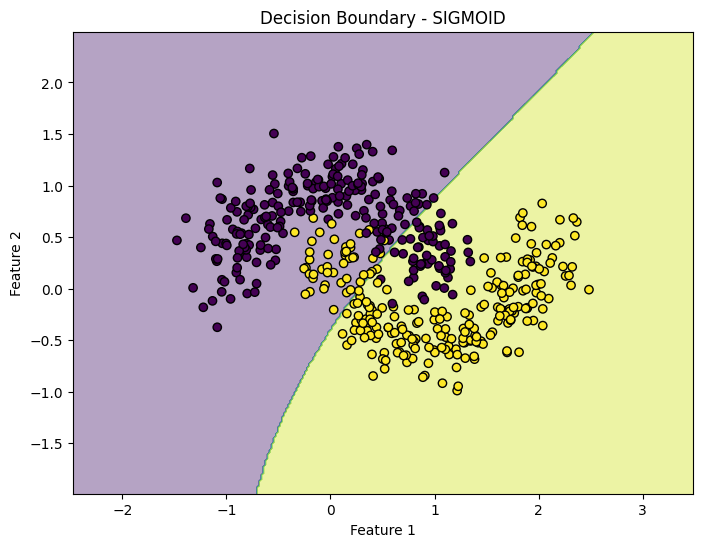

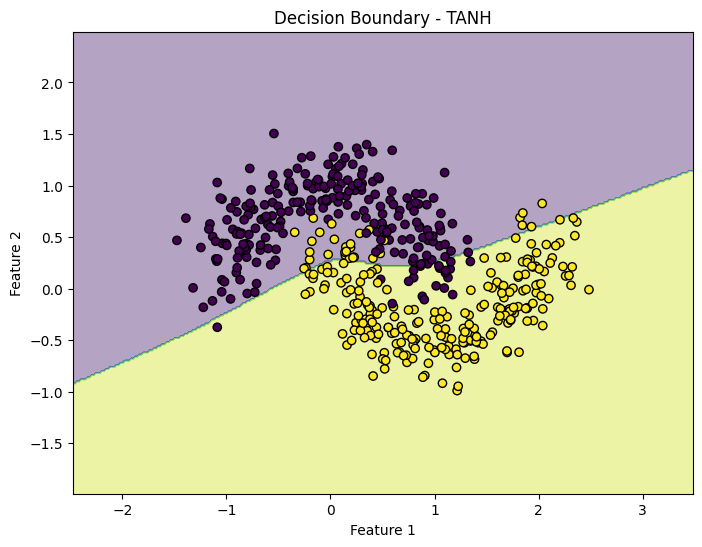


EXPERIMENT 3: Loss Function Comparison

Training with CROSSENTROPY...
Final Accuracy: 98.40%

Training with MSE...
Final Accuracy: 98.80%


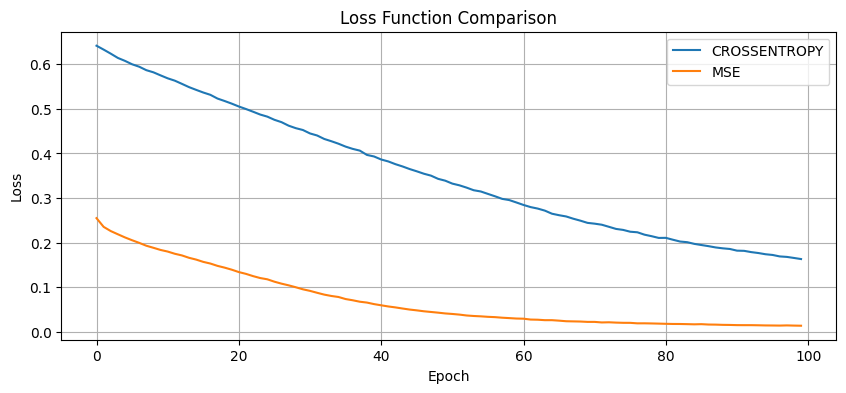


ALL EXPERIMENTS COMPLETE!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Activation functions
class ReLU:
    def forward(self,x):
        self.x=x
        return np.maximum(0,x)

    def backward(self,dout):
        return dout * (self.x>0)
    
class sigmoid:
    def forward(self,x):
        self.out=1/(1+np.exp(-np.clip(x,-500,500)))
        return self.out
    
class tanh:


class softmax: 

# LOSS FUNCTIONS
class MSE:

class MAE:
    

class CrossEntropy:



#Dense layer

class Dense:
    def __init__(self,input_dim,output_dim):

        self.W=np.random.randn(input_dim,output_dim)*np.sqrt(2.0/input_dim)
        self.b=np.zeros(1,output_dim)

        def forward(self,x):
            self.x=x
            return np.dot(x,self.W)+self.b
        
        def backward(self,dout,lr):
            dW=np.dot(self.x.T,dout)
            db=np.sum(dout,axis=0,keepdims=True)
            dx=np.dot(dout,self.W.T)

            self.W-=lr*dW
            self.b-=lr*db

        return display_latex
    
class MLP:

    def __init__(self,layersizes,activation='relu',loss='crossentropy'):
        self.layers=[]
        self.activaions=[]
        

        for i in range(len(layersizes)-1):
            self.layers.append(Dense(layersizes[i],layersizes[i+1]))

            if i<len(layersizes)-2:
                if activation=='relu':
                    self.activaions.append(ReLU())
                elif activation=='sigmoid':
                    self.activation.append(sigmoid())
                elif activation=="tanh":
                    self.activation.append(tanh())
                else:
                    self.activation.append(softmax())

        if loss=='crossentropy':
            self.loss_fn=CrossEntropy()
        elif loss=='mse':
            self.loss_fn=MSE()
        elif loss=="mae":
            self.loss_fn=MAE()    

    def forward(self,x):
        for layer,activation in zip(self.layers,self.activations):
            x=layer.forward(x)
            x=activation.forward(x)
        return x
    
    def backward(self,lr):
        dout=self.loss_fn.backward()

        for layer,activation in reversed(zip(self.layers,self.activaions)):
            dout=activation.backward(dout)
            dout=layer.backward(dout,lr)


    def train(self,X,y,epochs,lr,batch_size,X_val=None,y_val=None):
        for epoch in range(epochs):

            indices=np.random.permutation(len(X)):
            X_shuffled=X[indices]
            y_shuffled=y[indices]

            for i in range(0,len(X),batch_size):
                X_batch=X_shuffled[i:i+batch_size]
                y_batch=y_shuffled[i:i+batch_size]

                y_pred=self.forward(X_batch)
                loss=self.loss_fn.forward(y_pred,y_batch)

                self.backward(lr)
                

    

